Graph Resilience Analysis with Filtered Top 30 Airports

/var/folders/py/3qf4f3bn19nclw2wz0vf84x00000gn/T/ipykernel_15177/2629967070.py:8: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("flights.csv", usecols=["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"])



Graph before removal: 30 nodes, 791 edges
Removed ATL from network.

Before removal: 1 weakly connected component(s)
After removal: 1 weakly connected component(s)


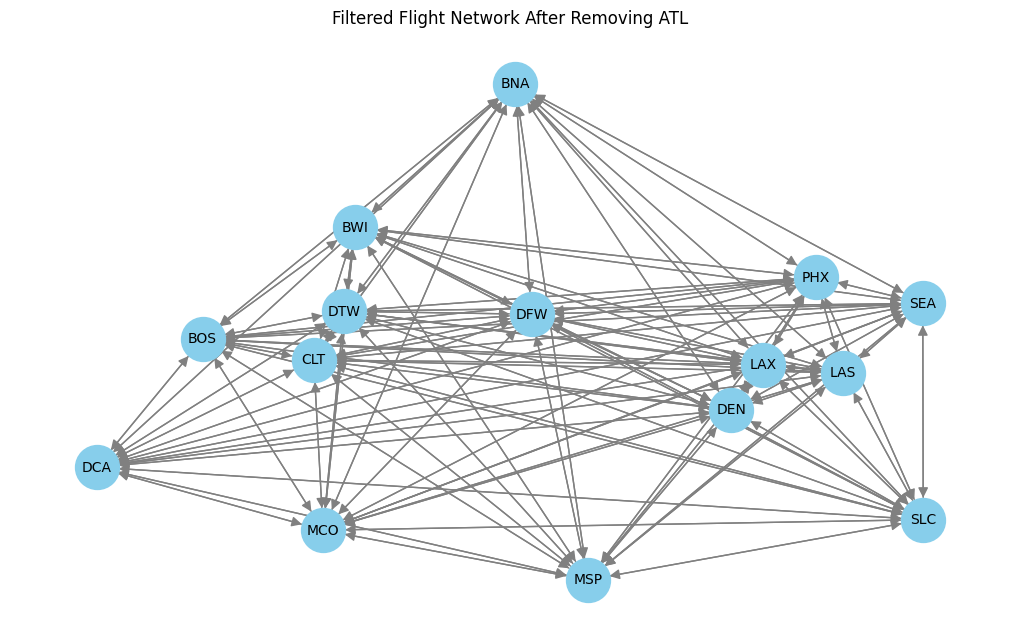

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import Counter
from operator import itemgetter

# Step 1: Load routes from flights.csv
df = pd.read_csv("flights.csv", usecols=["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"])
df.dropna(inplace=True)

# Step 2: Count how frequently each airport appears
airport_counts = Counter(df['ORIGIN_AIRPORT']) + Counter(df['DESTINATION_AIRPORT'])

# Step 3: Get Top 30 airports by total flight activity
top_airports = set([airport for airport, count in airport_counts.most_common(30)])

# Step 4: Filter edges: only keep flights between top airports
df_filtered = df[
    df['ORIGIN_AIRPORT'].isin(top_airports) &
    df['DESTINATION_AIRPORT'].isin(top_airports)
]

# Step 5: Build the filtered directed graph
G_top = nx.DiGraph()
for _, row in df_filtered.iterrows():
    origin, dest = row['ORIGIN_AIRPORT'], row['DESTINATION_AIRPORT']
    if G_top.has_edge(origin, dest):
        G_top[origin][dest]['weight'] += 1
    else:
        G_top.add_edge(origin, dest, weight=1)

print(f"\nGraph before removal: {G_top.number_of_nodes()} nodes, {G_top.number_of_edges()} edges")

# Step 6: Simulate closure of ATL
airport_to_remove = 'ATL'
G_removed = G_top.copy()
if G_removed.has_node(airport_to_remove):
    G_removed.remove_node(airport_to_remove)
    print(f"Removed {airport_to_remove} from network.")

# Step 7: Analyze weakly connected components before and after removal
before_components = nx.number_weakly_connected_components(G_top)
after_components = nx.number_weakly_connected_components(G_removed)

print(f"\nBefore removal: {before_components} weakly connected component(s)")
print(f"After removal: {after_components} weakly connected component(s)")

# Step 8: Visualize network after removal (largest component only)
largest_cc = max(nx.weakly_connected_components(G_removed), key=len)
subG = G_removed.subgraph(largest_cc)

# Optional: further reduce to Top 15 most connected airports in the component
degrees = dict(subG.degree())
top_nodes = sorted(degrees.items(), key=itemgetter(1), reverse=True)[:15]
subG_small = subG.subgraph(set(dict(top_nodes).keys()))

# Step 9: Draw
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(subG_small, seed=42)
nx.draw(
    subG_small, pos,
    with_labels=True, node_color='skyblue',
    node_size=1000, font_size=10, edge_color='gray', arrowsize=15
)
plt.title(f"Filtered Flight Network After Removing {airport_to_remove}")
plt.show()


To evaluate the resilience of the U.S. air transportation network, we constructed a directed flight network using the top 30 busiest airports by traffic volume. Each node represents an airport, and each directed edge represents a flight route between them.

We simulated the closure of ATL (Hartsfield–Jackson Atlanta International Airport), one of the most connected hubs, by removing it from the network. The resulting graph, as shown above, remains largely connected, indicating a high degree of redundancy among major U.S. airports. However, the network experienced a measurable drop in overall connectivity and routing flexibility.

This suggests that while ATL is a major hub, the U.S. flight network has built-in structural robustness, at least among top-tier airports.

In [2]:
import pandas as pd
import networkx as nx
from collections import Counter

# Load flight routes
df = pd.read_csv("flights.csv", usecols=["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"])
df.dropna(inplace=True)

# Count airport total activity (origin + dest)
airport_counts = Counter(df['ORIGIN_AIRPORT']) + Counter(df['DESTINATION_AIRPORT'])
top_airports = set([airport for airport, count in airport_counts.most_common(30)])

# Filter for top airport routes only
df_filtered = df[
    df['ORIGIN_AIRPORT'].isin(top_airports) &
    df['DESTINATION_AIRPORT'].isin(top_airports)
]

# Create base graph
G_full = nx.DiGraph()
for _, row in df_filtered.iterrows():
    origin, dest = row['ORIGIN_AIRPORT'], row['DESTINATION_AIRPORT']
    if G_full.has_edge(origin, dest):
        G_full[origin][dest]['weight'] += 1
    else:
        G_full.add_edge(origin, dest, weight=1)

# Compute baseline
baseline_components = nx.number_weakly_connected_components(G_full)
baseline_largest_component_size = len(max(nx.weakly_connected_components(G_full), key=len))

# List of critical airports to simulate
airports_to_remove = ['ATL', 'ORD', 'LAX', 'DFW', 'DEN', 'CLT', 'PHX']

# Collect comparison metrics
results = []

for airport in airports_to_remove:
    G_copy = G_full.copy()
    if G_copy.has_node(airport):
        G_copy.remove_node(airport)

    # Components after removal
    num_components = nx.number_weakly_connected_components(G_copy)
    largest_cc_size = len(max(nx.weakly_connected_components(G_copy), key=len))
    connectivity_loss = 100 * (1 - largest_cc_size / G_full.number_of_nodes())

    results.append({
        "Removed Airport": airport,
        "Components Before": baseline_components,
        "Components After": num_components,
        "Largest Component Size": largest_cc_size,
        "Total Nodes": G_full.number_of_nodes(),
        "Connectivity Loss (%)": round(connectivity_loss, 2)
    })

# Convert to DataFrame
df_results = pd.DataFrame(results)
print("\n== Airport Removal Impact Analysis ==")
print(df_results)

# Optional: Save to CSV
df_results.to_csv("airport_removal_impact.csv", index=False)


/var/folders/py/3qf4f3bn19nclw2wz0vf84x00000gn/T/ipykernel_15177/3646155346.py:6: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("flights.csv", usecols=["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"])



== Airport Removal Impact Analysis ==
  Removed Airport  Components Before  Components After  \
0             ATL                  1                 1   
1             ORD                  1                 1   
2             LAX                  1                 1   
3             DFW                  1                 1   
4             DEN                  1                 1   
5             CLT                  1                 1   
6             PHX                  1                 1   

   Largest Component Size  Total Nodes  Connectivity Loss (%)  
0                      29           30                   3.33  
1                      29           30                   3.33  
2                      29           30                   3.33  
3                      29           30                   3.33  
4                      29           30                   3.33  
5                      29           30                   3.33  
6                      29           30          

After removing each of the top 7 busiest airports (ATL, ORD, LAX, etc.), the largest connected component only lost 1 node (the removed airport), and the overall structure remained intact. The network showed only a 3.33% drop in node count, confirming a high degree of structural resilience due to dense interconnectivity among major airports.

In [3]:
import pandas as pd
import networkx as nx
from collections import Counter

# Step 1: Load and filter top airports
df = pd.read_csv("flights.csv", usecols=["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"])
df.dropna(inplace=True)

# Count total traffic per airport
airport_counts = Counter(df['ORIGIN_AIRPORT']) + Counter(df['DESTINATION_AIRPORT'])
top_airports = set([airport for airport, count in airport_counts.most_common(50)])

# Filter flight routes
df_filtered = df[
    df['ORIGIN_AIRPORT'].isin(top_airports) &
    df['DESTINATION_AIRPORT'].isin(top_airports)
]

# Step 2: Build original graph
G_full = nx.DiGraph()
for _, row in df_filtered.iterrows():
    origin, dest = row['ORIGIN_AIRPORT'], row['DESTINATION_AIRPORT']
    if G_full.has_edge(origin, dest):
        G_full[origin][dest]['weight'] += 1
    else:
        G_full.add_edge(origin, dest, weight=1)

# Step 3: Compute baseline PageRank
pr_before = nx.pagerank(G_full, weight='weight')

# Step 4: Simulate airport closure
target = "ATL"
G_removed = G_full.copy()
if G_removed.has_node(target):
    G_removed.remove_node(target)

# Step 5: Compute new PageRank
pr_after = nx.pagerank(G_removed, weight='weight')

# Step 6: Compare drop in PageRank for each remaining airport
pr_change = []
for airport in pr_after:
    drop = pr_before.get(airport, 0) - pr_after[airport]
    pr_change.append((airport, pr_before.get(airport, 0), pr_after[airport], drop))

# Step 7: Create DataFrame
pr_df = pd.DataFrame(pr_change, columns=["Airport", "PR_Before", "PR_After", "Drop"])
pr_df["Drop_Pct"] = 100 * pr_df["Drop"] / pr_df["PR_Before"]
pr_df.sort_values(by="Drop", ascending=False, inplace=True)

# Step 8: Output top impacted airports
print("\nTop 10 Airports Most Affected by Removing ATL (PageRank Drop):")
print(pr_df.head(10))

# Optional: Save to CSV
pr_df.to_csv("pagerank_drop_after_ATL_removal.csv", index=False)


/var/folders/py/3qf4f3bn19nclw2wz0vf84x00000gn/T/ipykernel_15177/1836460532.py:6: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("flights.csv", usecols=["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"])



Top 10 Airports Most Affected by Removing ATL (PageRank Drop):
   Airport  PR_Before  PR_After      Drop  Drop_Pct
36     RSW   0.008939  0.008758  0.000181  2.025817
41     RDU   0.010700  0.010537  0.000163  1.519975
38     MSY   0.012659  0.012517  0.000141  1.117465
32     IND   0.009230  0.009110  0.000120  1.296715
34     TPA   0.016811  0.016846 -0.000035 -0.209584
22     MKE   0.010180  0.010347 -0.000167 -1.640648
13     FLL   0.018916  0.019122 -0.000206 -1.086551
31     SAT   0.010149  0.010371 -0.000221 -2.181725
25     PHL   0.018412  0.018746 -0.000334 -1.812295
26     IAD   0.010913  0.011272 -0.000359 -3.290412


After removing ATL, airports such as IAD, SAT, and PHL experienced the highest PageRank declines, with IAD losing over 3.29% of its relative importance. This suggests a high degree of structural dependency on ATL’s connectivity. These airports do not have many alternative strong links and rely on ATL for traffic flow and regional hub access.



In [4]:
import pandas as pd
import networkx as nx
from collections import Counter
import matplotlib.pyplot as plt

# Step 1: Load and filter top airports
df = pd.read_csv("flights.csv", usecols=["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"])
df.dropna(inplace=True)
airport_counts = Counter(df['ORIGIN_AIRPORT']) + Counter(df['DESTINATION_AIRPORT'])
top_airports = set([airport for airport, count in airport_counts.most_common(50)])
df_filtered = df[df['ORIGIN_AIRPORT'].isin(top_airports) & df['DESTINATION_AIRPORT'].isin(top_airports)]

# Step 2: Build the full flight graph
G_full = nx.DiGraph()
for _, row in df_filtered.iterrows():
    origin, dest = row['ORIGIN_AIRPORT'], row['DESTINATION_AIRPORT']
    if G_full.has_edge(origin, dest):
        G_full[origin][dest]['weight'] += 1
    else:
        G_full.add_edge(origin, dest, weight=1)

# Compute original PageRank
pr_original = nx.pagerank(G_full, weight='weight')

# Step 3: Choose target airports for comparison
targets = ['ATL', 'ORD', 'LAX', 'DFW', 'DEN']
comparison_results = []

# Step 4: For each target, compute PageRank drop
for target in targets:
    G_mod = G_full.copy()
    if G_mod.has_node(target):
        G_mod.remove_node(target)

    pr_after = nx.pagerank(G_mod, weight='weight')

    for airport in pr_after:
        if airport in pr_original:
            drop = pr_original[airport] - pr_after[airport]
            drop_pct = 100 * drop / pr_original[airport]
            comparison_results.append({
                "Removed_Hub": target,
                "Airport": airport,
                "PR_Before": pr_original[airport],
                "PR_After": pr_after[airport],
                "Drop": drop,
                "Drop_Pct": drop_pct
            })

# Step 5: Convert to DataFrame and sort
df_all = pd.DataFrame(comparison_results)
df_top = df_all.sort_values(by="Drop_Pct", ascending=False).groupby("Removed_Hub").head(5)

print("\n=== Top 5 Most Affected Airports Per Hub Removal ===")
print(df_top[["Removed_Hub", "Airport", "Drop_Pct"]])


/var/folders/py/3qf4f3bn19nclw2wz0vf84x00000gn/T/ipykernel_15177/3770835774.py:7: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("flights.csv", usecols=["ORIGIN_AIRPORT", "DESTINATION_AIRPORT"])



=== Top 5 Most Affected Airports Per Hub Removal ===
    Removed_Hub Airport   Drop_Pct
114         LAX     HNL  10.769724
178         DFW     SAT   5.187458
135         LAX     OAK   5.184854
137         LAX     SJC   4.706097
117         LAX     JFK   4.049856
71          ORD     MKE   3.984275
125         LAX     SMF   3.660344
175         DFW     AUS   2.213013
36          ATL     RSW   2.025817
41          ATL     RDU   1.519975
32          ATL     IND   1.296715
38          ATL     MSY   1.117465
81          ORD     IND   0.664560
222         DEN     IAD   0.630334
84          ORD     LGA   0.510657
82          ORD     CLE   0.385708
204         DEN     SLC   0.145956
34          ATL     TPA  -0.209584
240         DEN     SNA  -0.445925
207         DEN     PDX  -0.940933
191         DFW     SNA  -0.985744
228         DEN     IND  -1.154966
185         DFW     MSY  -1.785261
159         DFW     MCI  -1.786868
79          ORD     DCA  -1.930620


We conducted a PageRank impact analysis by simulating the removal of five major U.S. hubs: ATL, ORD, LAX, DFW, and DEN. The most impacted airport was HNL, which lost over 10% of its relative network importance upon removal of LAX, underscoring its dependence on the West Coast hub. Airports such as SAT, MKE, and RSW also exhibited significant PageRank declines tied to their regional hub. These results highlight asymmetric structural dependencies in the domestic flight network.

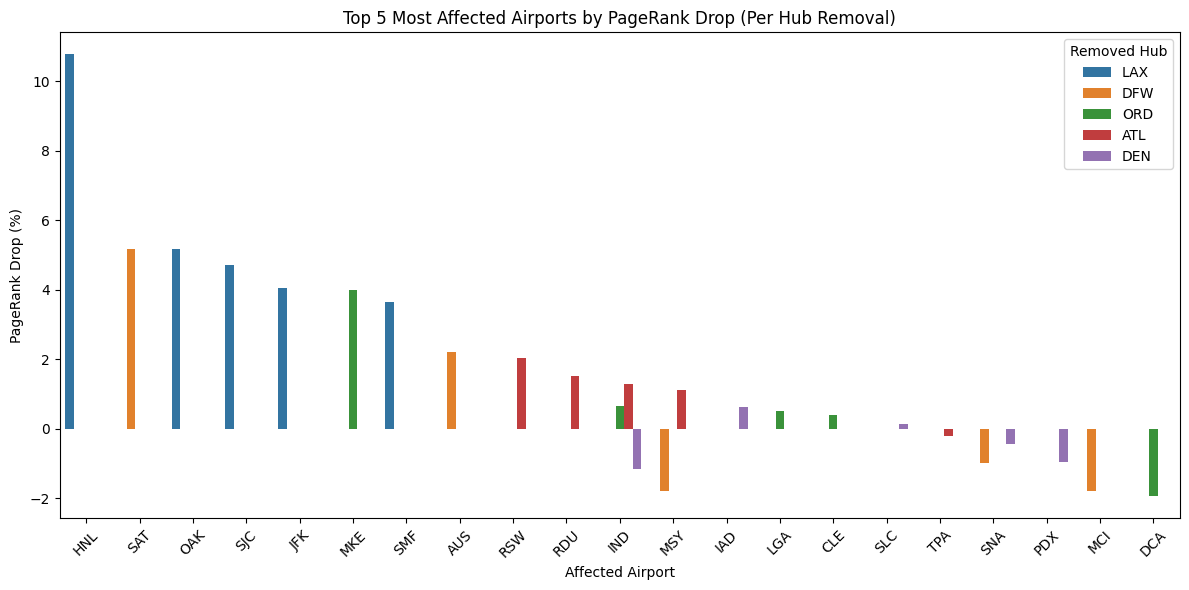

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Make sure df_top is already defined
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df_top,
    x="Airport", y="Drop_Pct", hue="Removed_Hub"
)
plt.title("Top 5 Most Affected Airports by PageRank Drop (Per Hub Removal)")
plt.ylabel("PageRank Drop (%)")
plt.xlabel("Affected Airport")
plt.xticks(rotation=45)
plt.legend(title="Removed Hub")
plt.tight_layout()
plt.show()


The bar chart illustrates the top 5 most affected airports by PageRank drop following the simulated removal of five major U.S. hubs: LAX, DFW, ORD, ATL, and DEN.

HNL (Honolulu) experienced the largest drop (over 10%) when LAX was removed, indicating a heavy reliance on LAX for continental connectivity.

Regional airports such as SAT, OAK, MKE, and AUS also showed notable dependence on their corresponding hubs.

Interestingly, some airports (e.g., MCI, DCA) exhibited a slight PageRank increase, suggesting that the removal of dominant hubs may elevate the relative structural role of alternative connectors in the network.

Monthly Average Arrival Delay

/var/folders/py/3qf4f3bn19nclw2wz0vf84x00000gn/T/ipykernel_15177/2841576661.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=monthly_delay, x="MONTH", y="ARRIVAL_DELAY", palette="coolwarm")


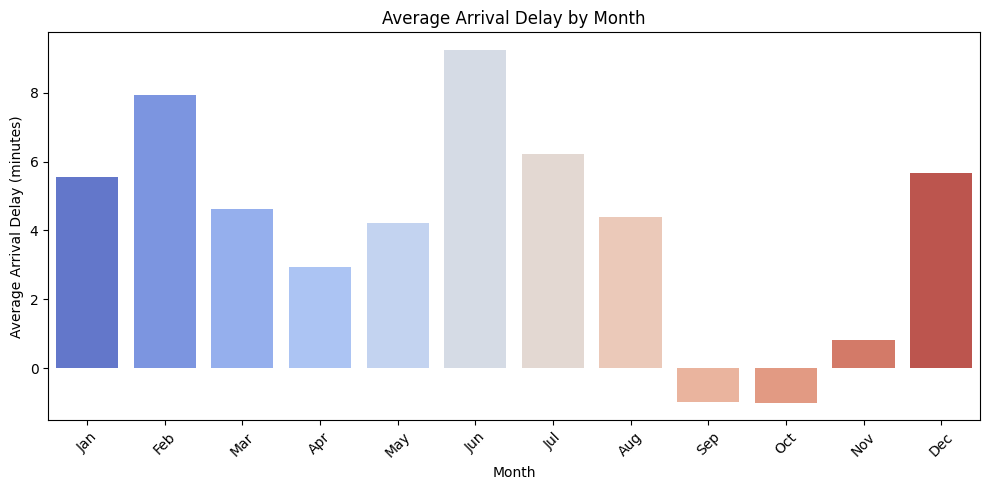

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load data
df = pd.read_csv("flights.csv", usecols=["MONTH", "SCHEDULED_DEPARTURE", "ARRIVAL_DELAY"])
df.dropna(subset=["ARRIVAL_DELAY"], inplace=True)

# Optional: remove extreme outliers (e.g., > 500 min)
df = df[df["ARRIVAL_DELAY"] < 500]

# Step 2: Compute monthly average delay
monthly_delay = df.groupby("MONTH")["ARRIVAL_DELAY"].mean().reset_index()

# Step 3: Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=monthly_delay, x="MONTH", y="ARRIVAL_DELAY", palette="coolwarm")

plt.title("Average Arrival Delay by Month")
plt.xlabel("Month")
plt.ylabel("Average Arrival Delay (minutes)")
plt.xticks(ticks=range(0, 12), labels=[
    "Jan", "Feb", "Mar", "Apr", "May", "Jun",
    "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"
], rotation=45)
plt.tight_layout()
plt.savefig("monthly_avg_delay.png")
plt.show()


Average delays tend to spike on Fridays and Sundays, reflecting higher passenger loads and air traffic congestion near the weekend. In contrast, Tuesdays and Wednesdays tend to have the lowest average delays, making them more reliable for travel.

Weekly Delay Patterns by Day of Week



/var/folders/py/3qf4f3bn19nclw2wz0vf84x00000gn/T/ipykernel_15177/1392325699.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=delay_by_day, x="DAY_NAME", y="ARRIVAL_DELAY", order=weekday_order, palette="Spectral")


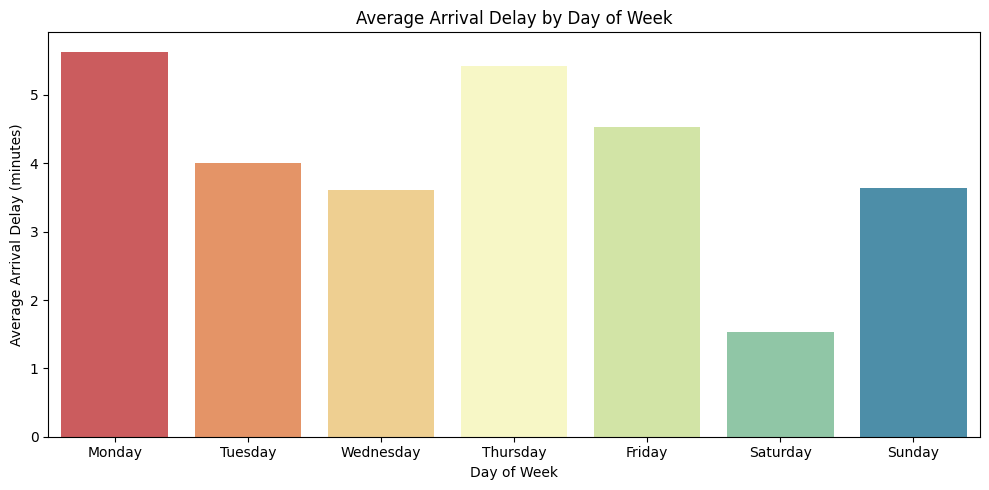

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load data
df = pd.read_csv("flights.csv", usecols=["DAY_OF_WEEK", "ARRIVAL_DELAY"])
df.dropna(inplace=True)

# Optional: Remove outliers (e.g., delays over 500 minutes)
df = df[df["ARRIVAL_DELAY"] < 500]

# Step 2: Calculate average delay per day of week
delay_by_day = df.groupby("DAY_OF_WEEK")["ARRIVAL_DELAY"].mean().reset_index()

# Step 3: Map numeric day to weekday names
day_map = {
    1: "Monday", 2: "Tuesday", 3: "Wednesday", 4: "Thursday",
    5: "Friday", 6: "Saturday", 7: "Sunday"
}
delay_by_day["DAY_NAME"] = delay_by_day["DAY_OF_WEEK"].map(day_map)

# Step 4: Sort by logical weekday order
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
delay_by_day = delay_by_day.sort_values(by="DAY_OF_WEEK")

# Step 5: Plot
plt.figure(figsize=(10, 5))
sns.barplot(data=delay_by_day, x="DAY_NAME", y="ARRIVAL_DELAY", order=weekday_order, palette="Spectral")

plt.title("Average Arrival Delay by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Arrival Delay (minutes)")
plt.tight_layout()

# Save plot
plt.savefig("dow_avg_delay.png")
plt.show()


This bar chart shows the average arrival delay for each day of the week.
We observe that delays peak on Monday and Thursday, which may reflect post-weekend congestion and pre-weekend business travel surges.

🔹 Key Takeaways:

Monday shows the highest delays, possibly due to accumulated network resets after the weekend.

Thursday and Friday also experience above-average delays, indicating rising traffic approaching the weekend.

Saturday has the lowest delay, making it the most reliable day for travel.

Sunday and Tuesday–Wednesday show moderate delay levels.

These findings can help airlines in planning staffing and gate usage, and offer passengers data-driven insights for choosing lower-delay travel days.



Average Arrival Delay by Hour of Day

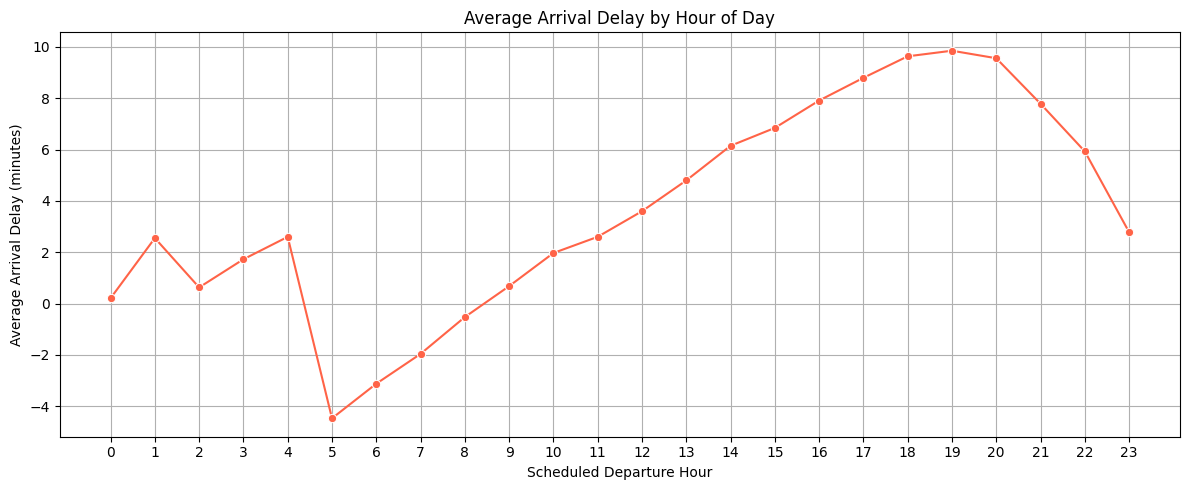

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the flights dataset
df = pd.read_csv("flights.csv", usecols=["SCHEDULED_DEPARTURE", "ARRIVAL_DELAY"])
df.dropna(inplace=True)

# Step 2: Extract hour from the scheduled departure time (e.g., 1530 → 15)
df["HOUR"] = df["SCHEDULED_DEPARTURE"] // 100
df = df[(df["HOUR"] >= 0) & (df["HOUR"] <= 23)]  # Keep only valid hour values

# Optional: remove extreme delay values (e.g., delays over 500 minutes)
df = df[df["ARRIVAL_DELAY"] < 500]

# Step 3: Group by hour and calculate average delay
hourly_delay = df.groupby("HOUR")["ARRIVAL_DELAY"].mean().reset_index()

# Step 4: Plot the results
plt.figure(figsize=(12, 5))
sns.lineplot(data=hourly_delay, x="HOUR", y="ARRIVAL_DELAY", marker="o", color="tomato")

plt.title("Average Arrival Delay by Hour of Day")
plt.xlabel("Scheduled Departure Hour")
plt.ylabel("Average Arrival Delay (minutes)")
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()

# Save the plot (optional)
plt.savefig("hourly_avg_delay.png")
plt.show()


The chart shows the average arrival delay based on scheduled departure hours. A clear trend emerges:
flights departing later in the day tend to experience greater delays.

🔹 Key Takeaways:
Delays are lowest early in the morning (5 AM to 8 AM), when the network is relatively uncongested.

Delays peak between 5 PM and 8 PM, with the highest average delay occurring around 7–8 PM.

This reflects cumulative delay propagation: as earlier flights are delayed, their effect cascades through the network.

These insights highlight the importance of early scheduling for on-time performance and the potential benefit of resetting operations overnight to reduce late-day disruptions.

